In [1]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import editdistance
from transer import Trainer
from transer import Dataset
#from transer import Model
from IPython.display import clear_output
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset = Dataset('train.csv')
words_vocab = dataset.words_vocab
trans_vocab = dataset.trans_vocab

In [3]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, trans_vocab_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.trans_vocab_len = trans_vocab_len
        
        
    def forward(self, batch_words, words_lens, batch_trans_in, mask_attention = None):
        outputs, hidden = self.encoder(batch_words)
        #print('hidden', hidden.size())
        logits  = []
        if mask_attention is None:
            for t in range(batch_trans_in.size(1)):
                logit, hidden   = self.decoder(batch_trans_in[:,t].unsqueeze(1), hidden, outputs)
                logits.append(logit)
        else:
            for t in range(batch_trans_in.size(1)):
                logit, hidden   = self.decoder(batch_trans_in[:,t].unsqueeze(1), hidden, outputs, mask_attention)
                logits.append(logit)
        logits = torch.stack(logits, 1)
        logits = logits.view(-1, self.trans_vocab_len)
        return logits
    
    def generate(self, bos_idx, eos_idx, batch_words):
        inp = [bos_idx]
        _, hidden = self.encoder(batch_words)

        for _ in range(100):
            inp_tensor = torch.LongTensor([[inp[-1]]]).to(batch_words.device)
            print(inp_tensor.size())
            pred, hidden   = self.decoder(inp_tensor, hidden)
            next_token = pred[-1].topk(1)[1].item()
            inp.append(next_token)
            if next_token == eos_idx:
                break
        return inp

In [4]:
class GeneralAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GeneralAttention, self).__init__()
        
        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(hidden_size,hidden_size, bias = False)
        
    def forward(self, outputs, hidden, mask = None):
        '''
        Inputs:
            outputs: (batch x seq_len x hidden) - outputs of encoder
            hidden:  (batch x hidden)           - last hidden cell of decoder
        Outputs:
            weights: (batch x seq_len x 1)
            context: (batch x hidden)
        '''
        hidden  = hidden.unsqueeze(-1)            
        x       = self.linear1(outputs)
        prod    = torch.matmul(outputs, hidden)
        if mask is not None:
            mask    = mask.unsqueeze(-1)
            prod.masked_fill_(1 - mask, -float('inf'))
        weights = F.softmax(prod, dim = 1)
        context = (weights*outputs).sum(dim = 1)
        return weights, context

In [5]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        
        self.linear1 = nn.Linear(2*hidden_size, hidden_size, bias = False)
        self.linear2 = nn.Linear(hidden_size,1, bias = False)
        
    def forward(self, outputs, hidden, mask = None):
        '''
        Inputs:
            outputs: (batch x seq_len x hidden) - outputs of encoder
            hidden:  (batch x hidden)           - last hidden cell of decoder
            mask:    (batch x seq_len)
        Outputs:
            weights: (batch x seq_len x 1)
            context: (batch x hidden)
        '''
        hidden = hidden.unsqueeze(1)                           #b x 1 x h
        hidden = hidden.repeat(1, outputs.size(1), 1)          #b x s x h
        concat = torch.cat([outputs, hidden], dim = 2)         #b x s x 2*h
        x   = self.linear1(concat)                             #b x s x h
        x   = F.tanh(x)                                        #b x s x h
        weights   = self.linear2(x)                            #b x s x 1
        if mask is not None:
            mask   = mask.unsqueeze(-1)                        #b x s x 1
            weights.masked_fill_(1-mask, -float('inf'))        #b x s x 1
        weights = F.softmax(weights, dim = 1)                  #b x s x 1
        context = (weights*outputs).sum(dim = 1)               #b x h
        
        return weights, context
        

In [6]:
attention = BahdanauAttention(64)

outputs = torch.rand(32,16,64)
hidden = torch.rand(32,64)
mask = torch.rand(32,16).type(torch.ByteTensor)

weights,context = attention(outputs, hidden, mask)
print(weights.size(), context.size())

torch.Size([32, 16, 1]) torch.Size([32, 64])


/home/raushan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [7]:
class Dotattention(nn.Module):
    def __init__(self):
        super(Dotattention, self).__init__()
        
    def forward(self, outputs, hidden, mask = None):
        '''
        Inputs:
            outputs: (batch x seq_len x hidden) - outputs of encoder
            hidden:  (batch x hidden)           - last hidden cell of decoder
            mask:    (batch x seq_len)
        Outputs:
            weights: (batch x seq_len x 1)
            context: (batch x hidden)
        '''
        hidden  = hidden.unsqueeze(-1)                 #b h 1   
        prod    = torch.matmul(outputs, hidden)        #b s 1
        if mask is not None:
            mask    = mask.unsqueeze(-1)               #b s 1
            prod.masked_fill_(1 - mask, -float('inf')) #b s 1
        weights = F.softmax(prod, dim = 1)             #b s 1
        context = (weights*outputs).sum(dim = 1)       #b h
        return weights, context

In [8]:
"""batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = dataset.get_batch(32, sort = True)
encoder = Encoder(len(words_vocab), 32, 64, pad_idx = words_vocab.pad_idx)
outputs, _= encoder(batch_words) 
dotattention = Dotattention()
hidden  = torch.rand(32,64)
mask = batch_words[0] != 0
weights, context = dotattention(outputs, hidden, mask = mask)
print(weights.size(), context.size())"""

'batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = dataset.get_batch(32, sort = True)\nencoder = Encoder(len(words_vocab), 32, 64, pad_idx = words_vocab.pad_idx)\noutputs, _= encoder(batch_words) \ndotattention = Dotattention()\nhidden  = torch.rand(32,64)\nmask = batch_words[0] != 0\nweights, context = dotattention(outputs, hidden, mask = mask)\nprint(weights.size(), context.size())'

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru       = nn.GRU(emb_size, hidden_size)
    
    def forward(self, source, source_lens=None, hidden=None):
        embedded = self.embedding(source)
        embedded = embedded.transpose(0, 1)
        
        if source_lens is not None:
            embedded = pack(embedded, source_lens)
        
        if hidden is not None:
            outs, hidden = self.gru(embedded, hidden)
        else:
            outs, hidden = self.gru(embedded)
        outs   = outs.transpose(0,1)
        hidden = hidden.squeeze(0) 
        return outs, hidden
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx, attention_type = None):
        super(Decoder, self).__init__()
        
        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size
        self.attention_type = attention_type
        #assert attention_type in ["dot", "bahdanau", "general"]
            
        if attention_type =='dot':
            self.attention = Dotattention()
        if attention_type == 'bahdanau':
            self.attention = BahdanauAttention(hidden_size)
        if attention_type == 'general':
            self.attention = GeneralAttention(hidden_size)
                
        #self.attention   = GeneralAttention(hidden_size)
        #self.attention = BahdanauAttention(hidden_size)
        #self.attention = Dotattention()
        self.embedding   = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru_cell    = nn.GRUCell((emb_size+hidden_size), hidden_size)
        self.gru_cell1   = nn.GRUCell(emb_size, hidden_size)
        self.linear_out  = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, target, hidden, outputs, mask = None):
        batch_size = target.size(0) 
        embedded = self.embedding(target)
        embedded = embedded.squeeze(1)
        
        if self.attention_type is not None:
            #print(outputs.size(), hidden.size())
            _,context = self.attention(outputs, hidden, mask)
            #print(embedded.size(), context.size())
            x_t = torch.cat([embedded, context], dim = 1)
            hidden = self.gru_cell(x_t, hidden)
            pred = self.linear_out(hidden)
        else:
            hidden = self.gru_cell1(embedded, hidden)
            pred = self.linear_out(hidden)
            
        return pred, hidden

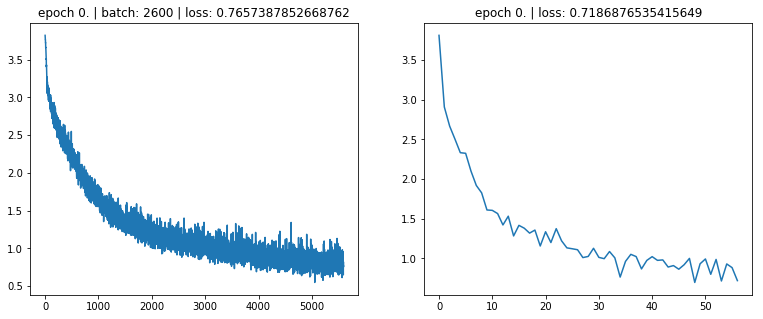

KeyboardInterrupt: 

In [10]:
encoder = Encoder(len(words_vocab), 32, 64, pad_idx = words_vocab.pad_idx)
decoder = Decoder(len(trans_vocab), 32, 64, pad_idx = trans_vocab.pad_idx)

model   = Model(encoder, decoder, len(trans_vocab)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

batch_size = 32
num_epochs = 2

totrain = Trainer(dataset, model, optimizer, criterion)
totrain.train(num_epochs, batch_size)


In [11]:
def _print(val):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = dataset.get_batch(1, sort=True, val=val)
    batch_words     = batch_words.to(device)
    batch_trans_out = batch_trans_out.to(device)


    inp = model.generate(words_vocab.sos_idx, words_vocab.eos_idx, batch_words)
            
    tokens = [trans_vocab.idx2token(idx) for idx in inp if idx not in [trans_vocab.sos_idx,
                                                                                     trans_vocab.eos_idx,
                                                                                     trans_vocab.pad_idx]]
    print('Src: ', ''.join([words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    print('Real:', ''.join([trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [trans_vocab.sos_idx,
                                                                            trans_vocab.eos_idx,
                                                                            trans_vocab.pad_idx]]))

In [12]:
for _ in range(10):
    _print(True)
    print()

torch.Size([1, 1])


TypeError: forward() missing 1 required positional argument: 'outputs'